# Algoritmo de valoración de precios de inmuebles en propiedad no horizontal

En las siguientes linea de codigo buscaremos crear un algoritmo que sea capaz de valorar adecuadamente los inmuebles de propiedad horizontal a partir de distintos enfoques.

In [1]:
import sys
import os
os.chdir('C:\\Users\\carli\\Dropbox\\Carlos Arturo Ramírez Pinto\\Files\\Universidad\\Kaggle\\El Algoritmo es Correcto')
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import json
 # Importando el modelo de RandomForest en problemas de regresión
from sklearn.ensemble import RandomForestRegressor
import re
from patsy import dmatrix, demo_data, ContrastMatrix, Poly

print("Cargando bases de datos de valores de referencia mt2")
#Cargar geojson de metro cuadrado de referencia
metro_cuadrado_ref=gpd.read_file("mapas_bogota\\metrocuadrado_ref.geojson")
# valores de referencia que pertenecen a los años más recientes, mayores a 2018
lista_ano=["2018-01-01","2019-01-01","2020-01-01"]
metro_cuadrado_ref["ano_rec"]=metro_cuadrado_ref["ANO"].apply(lambda x: x in lista_ano)
metro_cuadrado_ref=metro_cuadrado_ref[metro_cuadrado_ref["ano_rec"]==True]


#Creamos el posible scacodigo (codigo de barrios) suponiendo que los 6 primeros digitos corresponden al valor del codigo del barrio

metro_cuadrado_ref["pos_scacodigo"]=metro_cuadrado_ref.MANCODIGO.str.slice(0,6)
print("Numero de barrios: ",len(metro_cuadrado_ref.pos_scacodigo.unique()))
print("Terminado")


print("Cargando bases de datos de Colegios, Catastro, y datos de habi")
#Cargamos el mapa catastral de Bogotá. Colegios, Habi
col=gpd.read_file('mapas_bogota\\colegios.json')
bog=gpd.read_file("mapas_bogota\\bogota_catastral.json")
habi_train=pd.read_csv("datos_habi\\train_data.csv")
habi_test=pd.read_csv("datos_habi\\test_data.csv")
print("Terminado")
habi_train["test"]=0
habi_test["test"]=1
habi=pd.concat([habi_train,habi_test],axis=0)

print("Creando geometrias de Habi")
#Crear shape files a los datos de Habi para poder plotearlos en el mapa de Bogotá.
df=gpd.GeoDataFrame(habi, geometry=gpd.points_from_xy(habi.longitud, habi.latitud))

Cargando bases de datos de valores de referencia mt2
Numero de barrios:  1053
Terminado
Cargando bases de datos de Colegios, Catastro, y datos de habi
Terminado
Creando geometrias de Habi


In [2]:
def crear_geodf(barrio,metro_cuadrado_ref,bog):
    if barrio==1:
        agg_v_ref_scacod=metro_cuadrado_ref.groupby("pos_scacodigo").agg({'V_REF':['mean','median']})
        agg_v_ref_scacod.reset_index(level=0,inplace=True)
        agg_v_ref_scacod.columns.droplevel()
        agg_v_ref_scacod.columns.values[0]="geo_unit"
        agg_v_ref_scacod.columns.values[1]="vref_mean"
        agg_v_ref_scacod.columns.values[2]="vref_median"
        # Merge entre los valores medios de referencia por barrio y el mapa catastral de bogotá
        result_df=bog.merge(agg_v_ref_scacod,left_on="scacodigo",right_on="pos_scacodigo",how="left")
        
    elif barrio==0:
        result_df=metro_cuadrado_ref.groupby("MANCODIGO").agg({'V_REF':['mean','median'],'geometry':'unique'})
        result_df.reset_index(level=0,inplace=True)
        result_df.iloc[:,3]=result_df.iloc[:,3].apply(lambda x: x[0])
        result_df.columns.droplevel()
        result_df.columns.values[3]="geometry"
        result_df=gpd.GeoDataFrame(result_df, geometry=result_df.iloc[:,3])
        result_df.columns.values[0]="geo_unit"
        result_df.columns.values[1]="vref_mean"
        result_df.columns.values[2]="vref_median"
    
    return result_df

In [3]:
barrio=1
geo_df=crear_geodf(barrio,metro_cuadrado_ref,bog)
# En esta parte join espacial
if barrio==0:
    geo_df.columns=pd.Index(["geo_unit","vref_mean","vref_median","geometry"])
tot_df=gpd.sjoin(df,geo_df,how="left",op="intersects")
df=tot_df


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
<ipython-input-3-1b6dfb721253>:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  tot_df=gpd.sjoin(df,geo_df,how="left",op="intersects")


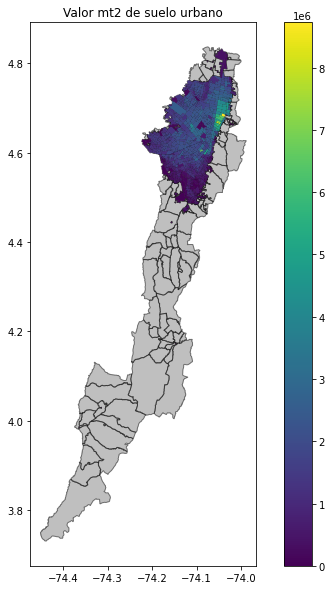

In [22]:
ax=bog.plot(figsize=(10, 10),color="grey",edgecolor="black", alpha=0.5)
ax.set_title("Valor mt2 de suelo urbano")

fig=geo_df.plot(column="vref_mean",ax=ax,legend=True)
plt.savefig('mapa__coropletico_mt2.jpg')

NameError: name 'test_df' is not defined

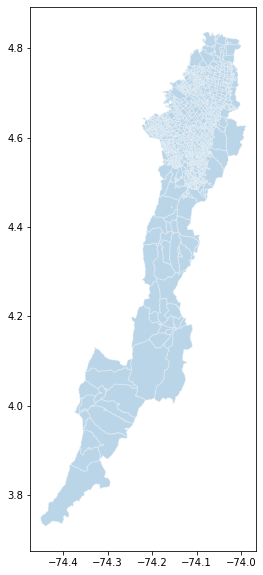

Signature: fig.suptitle(t, **kwargs)
Docstring:
Add a centered title to the figure.

Parameters
----------
t : str
    The title text.

x : float, default 0.5
    The x location of the text in figure coordinates.

y : float, default 0.98
    The y location of the text in figure coordinates.

horizontalalignment, ha : {'center', 'left', right'}, default: 'center'
    The horizontal alignment of the text relative to (*x*, *y*).

verticalalignment, va : {'top', 'center', 'bottom', 'baseline'}, default: 'top'
    The vertical alignment of the text relative to (*x*, *y*).

fontsize, size : default: :rc:`figure.titlesize`
    The font size of the text. See `.Text.set_size` for possible
    values.

fontweight, weight : default: :rc:`figure.titleweight`
    The font weight of the text. See `.Text.set_weight` for possible
    values.

Returns
-------
text
    The `.Text` instance of the title.

Other Parameters
----------------
fontproperties : None or dict, optional
    A dict of font propert

In [4]:
lista_var_dummies=['ascensor', 'balcon', 'banos', 'banoservicio',
       'conjuntocerrado', 'cuartoservicio', 'deposito', 'estrato', 'estudio',
       'garajes', 'gimnasio', 'habitaciones', 'halldealcobas',
       'parqueaderovisitantes', 'piscina', 'piso', 'porteria', 'remodelado',
       'saloncomunal', 'terraza', 'tiempodeconstruido', 'vigilancia', 'vista',
       'zonalavanderia', 'tipoinmueble',
       'tiponegocio','geo_unit']
lista_var_float=['ascensor', 'balcon', 'banos', 'banoservicio',
       'conjuntocerrado', 'cuartoservicio', 'deposito', 'estrato', 'estudio',
       'garajes', 'gimnasio', 'habitaciones', 'halldealcobas',
       'parqueaderovisitantes', 'piscina', 'piso', 'porteria', 'remodelado',
       'saloncomunal', 'terraza', 'vigilancia',
       'zonalavanderia']
lista_var_dummies_2=['ascensor', 'balcon', 'banos', 'banoservicio',
       'conjuntocerrado', 'cuartoservicio', 'deposito', 'estrato', 'estudio',
       'garajes', 'gimnasio', 'habitaciones', 'halldealcobas',
       'parqueaderovisitantes', 'piscina', 'piso', 'porteria', 'remodelado',
       'saloncomunal', 'terraza', 'tiempodeconstruido', 'vigilancia', 'vista',
       'zonalavanderia', 'tipoinmueble',
       'tiponegocio','geo_unit']
list_var_float_st=["area","vref_mean","vref_median"]

In [24]:
test_df=df[df["test"]==True]
test_df.shape
# Creando un buffer de 800 metros de radio alrededor de los puntos de test
test_df.loc[:,"buffer_zone"]=test_df.geometry.buffer(0.008)
buffer_zone=test_df["buffer_zone"]
buffer_zone=gpd.GeoDataFrame(geometry=buffer_zone)

C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


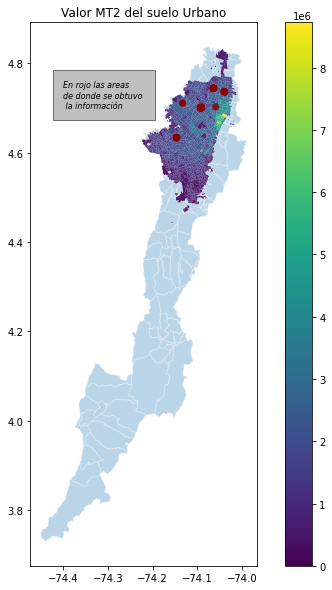

In [46]:
ax=bog.plot(alpha=0.3, edgecolor="white", figsize=(10,10))
#bx=

ax.text(-74.4, 4.7, 'En rojo las areas  \nde donde se obtuvo \n la información', style='italic', fontsize=8,
        bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
ax.set_title("Valor MT2 del suelo Urbano")
bx=geo_df.plot(column="vref_mean",ax=ax,legend=True,alpha=0.9)
test_df.buffer_zone.plot(ax=bx, alpha=0.8, color="darkred")
#text
plt.savefig('mapa__coropletico_mt2.jpg')
#plt.savefig("mapa_buffer.jpg")

In [7]:
del df["index_right"]
buffer_train_df=gpd.sjoin(df[df["test"]==0],buffer_zone,how="inner",op="intersects")

In [8]:
buffer_train_df.reset_index(drop=True,inplace=True)
buffer_train_df=buffer_train_df.loc[(buffer_train_df.id.duplicated(keep="first"))==False,:]

In [9]:
buffer_train_df.shape

(24251, 46)

In [10]:
buffer_df=buffer_train_df.append(df[df["test"]==1])

In [57]:
def pre_procesamiento(df):
    # Eliminar inmuebles que posean más de 200 baños y 200 habitaciones, debido a que es irrealista dicha condición para el area que ocupan
    df=df.loc[(df["banos"]<=200) & (df["habitaciones"]<=200),:]
    # Ajustar valores de tiempo de construido de "ntre 0 y 5 años" por "Entre 0 y 5 años"
    df["tiempodeconstruido"]=df["tiempodeconstruido"].str.replace("ntre 0 y 5 años","Entre 0 y 5 años")
    #Ajustar los valores de tiempo de construido de "Remodelado" por NaN )Talvez sea bueno no hacerlo. Afecta a 2013 listings que ya de por si que fueron remodelados
    # df["tiempodeconstruido"][df['tiempodeconstruido']=="Remodelado"]=np.nan
    #Ajustar variable tipo de negocio "Venta y arriendo" por "Venta Y Arriendo"
    df["tiponegocio"]=df["tiponegocio"].str.replace("Venta y arriendo","Venta Y Arriendo")
     # Eliminamos las casas que tengan un valor de metro cuadrado por encima de 20 millones de pesos. Estas viviendas seguramente 
    # tendrán caracteristicas de lujo que no son captadas por la base de datos o por el algoritmo y solo agregarían ruido a la muestra. 
    df["pr_mt2"]=df["valorventa"]/df["area"]
    # Estandarizamos el valor del precio del metro cuadrado de los apartamentos restandole el valor del precio medio del
    # valor del metro cuadrado del suelo del barrio en donde se encuentra ubicado el listing
    
    df["pr_mt2_est"]=df["pr_mt2"]-df["vref_mean"]
    #Eliminamos las observaciones que son NaN en la variable creada ya sea porqué no fue posible calcular el valor promedio del metro cuadrado
    # dlel suelo de esa area, o porqué el area reportada es cero. 
    #df=df.loc[(df["pr_mt2_est"].isnull())==False,:]
    df=df.loc[df["pr_mt2"]<=20000000]
    #Transformamos a las variables que deberían ser categoricas, en variables tipo str
    df.loc[:,lista_var_float]=df.loc[:,lista_var_float].apply(lambda x: x.astype(str),axis=0)
    # Convertimos en NaN values todos aquellos valores missing o ya NaN
    df[df.isnull()]=np.nan

    X_dummies=pd.get_dummies(data=df[lista_var_dummies],dummy_na=False)
    model_df=pd.concat([df[["id","pr_mt2","test","vref_mean","area"]],X_dummies],axis=1)
    return model_df
    

In [58]:
model_df=pre_procesamiento(buffer_df)
print(model_df.shape)
train=model_df.loc[model_df.test==0]
test=model_df.loc[model_df.test==1]
train_label=train["pr_mt2"]
train_features=train.drop(["pr_mt2","id"],axis=1)
train_label=train_label.reset_index(drop=True)
train_features=train_features.reset_index(drop=True)

test_label=test["pr_mt2"]
test_features=test.drop(["pr_mt2","id"],axis=1)
test_label= test_label.reset_index(drop=True)
test_features= test_features.reset_index(drop=True)
print("Train label: ", train_label.shape)
print("Train features: ",train_features.shape)

print("Test label: ", test_label.shape)
print("Test features: ", test_features.shape)

C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


(24020, 213)
Train label:  (23967,)
Train features:  (23967, 211)
Test label:  (53,)
Test features:  (53, 211)


In [59]:
train_features.columns

Index(['test', 'vref_mean', 'area', 'ascensor_1.0', 'ascensor_nan',
       'balcon_1.0', 'balcon_nan', 'banos_0.0', 'banos_1.0', 'banos_10.0',
       ...
       'geo_unit_009121', 'geo_unit_009124', 'geo_unit_009125',
       'geo_unit_009126', 'geo_unit_009128', 'geo_unit_009130',
       'geo_unit_009132', 'geo_unit_009135', 'geo_unit_009215',
       'geo_unit_009231'],
      dtype='object', length=211)

In [64]:
# Importando el modelo de RandomForest en problemas de regresión
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 250, random_state = 42,max_features='sqrt', criterion="mae",max_depth=40,min_samples_split=30)
# Train the model on training data
rf.fit(train_features, train_label)

RandomForestRegressor(criterion='mae', max_depth=40, max_features='sqrt',
                      min_samples_split=30, n_estimators=250, random_state=42)

In [65]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_label)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_label)
print("Mape: ",round(np.mean(mape),5), "%.")
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 4), '%.')

Mean Absolute Error: 251676.86 degrees.
Mape:  9.69666 %.
Accuracy: 90.3033 %.


<AxesSubplot:>

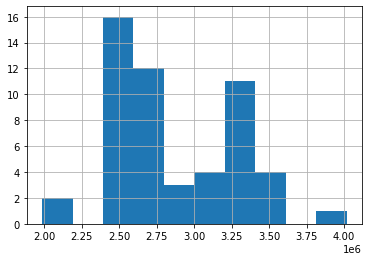

In [66]:
results={'id':list(test_df["id"]),'valormt2_predicted':list(predictions)}
results=pd.DataFrame(results)
results.shape
results["valormt2_predicted"].hist()

In [67]:
results.to_csv("results\\submission_first_rf.csv",index=False)

## Enfoque 2

En este enfoque vamos calcular dos modelos. Uno con aquellas obs para las cuales tenemos datos del valor de referencia del mt2 de suelo promedio y otro modelo con aquellos que no. Se mantiene todo igual hasta el siguiente paso.

In [68]:
def pre_procesamiento(df):
    # Eliminar inmuebles que posean más de 200 baños y 200 habitaciones, debido a que es irrealista dicha condición para el area que ocupan
    df=df.loc[(df["banos"]<=200) & (df["habitaciones"]<=200),:]
    # Ajustar valores de tiempo de construido de "ntre 0 y 5 años" por "Entre 0 y 5 años"
    df["tiempodeconstruido"]=df["tiempodeconstruido"].str.replace("ntre 0 y 5 años","Entre 0 y 5 años")
    #Ajustar los valores de tiempo de construido de "Remodelado" por NaN )Talvez sea bueno no hacerlo. Afecta a 2013 listings que ya de por si que fueron remodelados
    # df["tiempodeconstruido"][df['tiempodeconstruido']=="Remodelado"]=np.nan
    #Ajustar variable tipo de negocio "Venta y arriendo" por "Venta Y Arriendo"
    df["tiponegocio"]=df["tiponegocio"].str.replace("Venta y arriendo","Venta Y Arriendo")
     # Eliminamos las casas que tengan un valor de metro cuadrado por encima de 20 millones de pesos. Estas viviendas seguramente 
    # tendrán caracteristicas de lujo que no son captadas por la base de datos o por el algoritmo y solo agregarían ruido a la muestra. 
    df["pr_mt2"]=df["valorventa"]/df["area"]
    # Estandarizamos el valor del precio del metro cuadrado de los apartamentos restandole el valor del precio medio del
    # valor del metro cuadrado del suelo del barrio en donde se encuentra ubicado el listing
    
    df["pr_mt2_est"]=df["pr_mt2"]-df["vref_mean"]
    #Eliminamos las observaciones que son NaN en la variable creada ya sea porqué no fue posible calcular el valor promedio del metro cuadrado
    # dlel suelo de esa area, o porqué el area reportada es cero. 
    #df=df.loc[(df["pr_mt2_est"].isnull())==False,:]
    df=df.loc[df["pr_mt2"]<=20000000]
    #Transformamos a las variables que deberían ser categoricas, en variables tipo str
    df.loc[:,lista_var_float]=df.loc[:,lista_var_float].apply(lambda x: x.astype(str),axis=0)
    # Convertimos en NaN values todos aquellos valores missing o ya NaN
    df[df.isnull()]=np.nan

    X_dummies=pd.get_dummies(data=df[lista_var_dummies],dummy_na=False)
    model_df=pd.concat([df[["id","pr_mt2","test","vref_mean","area"]],X_dummies],axis=1)
    return model_df
    

In [24]:
buffer_df.columns

Index(['id', 'area', 'ascensor', 'balcon', 'banos', 'banoservicio',
       'conjuntocerrado', 'cuartoservicio', 'deposito', 'estrato', 'estudio',
       'garajes', 'gimnasio', 'habitaciones', 'halldealcobas',
       'parqueaderovisitantes', 'piscina', 'piso', 'porteria', 'remodelado',
       'saloncomunal', 'terraza', 'tiempodeconstruido', 'vigilancia', 'vista',
       'zonalavanderia', 'valoradministracion', 'valorventa', 'tipoinmueble',
       'tiponegocio', 'latitud', 'longitud', 'test', 'geometry', 'cartodb_id',
       'scacodigo', 'scatipo', 'scanombre', 'shape_leng', 'shape_area',
       'MOVEMENT_ID', 'DISPLAY_NAME', 'geo_unit', 'vref_mean', 'vref_median',
       'index_right'],
      dtype='object')

In [14]:
model_df=pre_procesamiento(buffer_df)
print(model_df.shape)
train=model_df.loc[model_df.test==0]
test=model_df.loc[model_df.test==1]

train_vref_not_null=train.loc[(train.vref_mean.isnull()==False)]
train_vref_null=train.loc[(train.vref_mean.isnull()==True)]

train_vref_not_null_label=train_vref_not_null["pr_mt2"]
train_vref_null_label=train_vref_null["pr_mt2"]

train_vref_not_null_features=train_vref_not_null.drop(["pr_mt2","id"],axis=1)
train_vref_null_features=train_vref_null.drop(["pr_mt2","vref_mean","id"],axis=1)

#Reseteando los indices
train_vref_not_null_label=train_vref_not_null_label.reset_index(drop=True)
train_vref_not_null_features=train_vref_not_null_features.reset_index(drop=True)
# Ahora para los null vref
train_vref_null_label=train_vref_not_null_label.reset_index(drop=True)
train_vref_null_features=train_vref_null_features.reset_index(drop=True)



test_vref_not_null=test.loc[(test.vref_mean.isnull()==False)]
test_vref_null=test.loc[(test.vref_mean.isnull()==True)]

test_vref_not_null_label=test_vref_not_null["pr_mt2"]
test_vref_not_null_features=test_vref_not_null.drop(["pr_mt2","id"],axis=1)


test_vref_not_null_label= test_vref_not_null_label.reset_index(drop=True)
test_vref_not_null_features= test_vref_not_null_features.reset_index(drop=True)

test_vref_null_label=test_vref_null["pr_mt2"]
test_vref_null_features=test_vref_null.drop(["pr_mt2","vref_mean","id"],axis=1)


test_vref_null_label= test_vref_null_label.reset_index(drop=True)
test_vref_null_features= test_vref_null_features.reset_index(drop=True)
print("Ahora se imprimiran los tamaños de las matrices de vref not null")
print("Train label: ", train_vref_not_null_label.shape)
print("Train features: ",train_vref_not_null_features.shape)

print("Test label: ", test_vref_not_null_label.shape)
print("Test features: ", test_vref_not_null_features.shape)

print("Ahora se imprimiran los tamaños de las matrices de vref== null")
print("Train label: ", train_vref_null_label.shape)
print("Train features: ",train_vref_null_features.shape)

print("Test label: ", test_vref_null_label.shape)
print("Test features: ", test_vref_null_features.shape)

C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


(24020, 213)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (23967,)
Train features:  (23967, 211)
Test label:  (53,)
Test features:  (53, 211)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (23967,)
Train features:  (0, 210)
Test label:  (0,)
Test features:  (0, 210)


In [25]:
# Importando el modelo de RandomForest en problemas de regresión
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 150, random_state = 42,max_features=0.2, criterion="mae",max_depth=30,min_samples_split=30)
# Train the model on training data
rf.fit(train_vref_not_null_features, train_vref_not_null_label)

RandomForestRegressor(criterion='mae', max_depth=30, max_features=0.2,
                      min_samples_split=30, n_estimators=150, random_state=42)

In [27]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_vref_not_null_features)
# Calculate the absolute errors
errors = abs(predictions - test_vref_not_null_label)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_vref_not_null_label)
print("Mape: ",round(np.mean(mape),5), "%.")
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 4), '%.')

Mean Absolute Error: 164048.02 degrees.
Mape:  5.84208 %.
Accuracy: 94.1579 %.


(array([ 2.,  9., 18.,  2.,  2.,  3.,  7.,  9.,  0.,  1.]),
 array([1886827.33959953, 2101230.55503706, 2315633.77047458,
        2530036.9859121 , 2744440.20134963, 2958843.41678715,
        3173246.63222468, 3387649.8476622 , 3602053.06309972,
        3816456.27853725, 4030859.49397477]),
 <BarContainer object of 10 artists>)

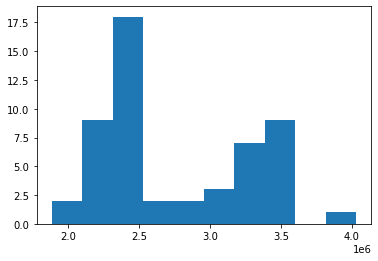

In [28]:
results={'id':list(test_df["id"]),'valormt2_predicted':list(predictions)}
results=pd.DataFrame(results)
print(results.shape)
results.to_csv("results\\submission.csv",index=False)
results.valormt2_predicted.hist()

<BarContainer object of 211 artists>

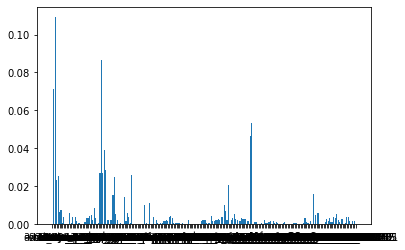

In [33]:
plt.bar(height=rf.feature_importances_,x=train_vref_not_null_features.columns)

In [ ]:
### Ahora estimamos el modelo que posee vref null

### Enfoque 3: Modelo por obs de test utilizando las train obs del buffer:

In [72]:
# Creando un buffer de 800 metros radio
test_df.loc[:,"buffer_zone"]=test_df.geometry.buffer(0.008)
buffer_zone=test_df["buffer_zone"]
buffer_zone=gpd.GeoDataFrame(geometry=buffer_zone)

In [73]:
tot_predictions=list()
for i in range(0,len(buffer_zone)):
    print(i)
    zone=buffer_zone.iloc[i,0]

    #del df["index_right"]
    g=pd.DataFrame({'geometry':zone},index=[0])
    temp_buffer_zone=gpd.GeoDataFrame(g,geometry="geometry")
    temp_buffer_df=gpd.sjoin(df[df["test"]==0],temp_buffer_zone,how="inner",op="intersects")
    temp_buffer_df.reset_index(drop=True,inplace=True)
    temp_buffer_df=temp_buffer_df.loc[(temp_buffer_df.id.duplicated(keep="first"))==False,:]
    print(temp_buffer_df.shape)
    temp_buffer_df=temp_buffer_df.append(df[df["test"]==1].iloc[i])
    print(temp_buffer_df.shape)
    model_df=pre_procesamiento(temp_buffer_df)
    print(model_df.shape)
    train=model_df.loc[model_df.test==0]
    test=model_df.loc[model_df.test==1]

    train_vref_not_null=train.loc[(train.vref_mean.isnull()==False)]
    train_vref_null=train.loc[(train.vref_mean.isnull()==True)]

    train_vref_not_null_label=train_vref_not_null["pr_mt2"]
    train_vref_null_label=train_vref_null["pr_mt2"]

    train_vref_not_null_features=train_vref_not_null.drop(["pr_mt2","id"],axis=1)
    train_vref_null_features=train_vref_null.drop(["pr_mt2","vref_mean","id"],axis=1)

    #Reseteando los indices
    train_vref_not_null_label=train_vref_not_null_label.reset_index(drop=True)
    train_vref_not_null_features=train_vref_not_null_features.reset_index(drop=True)
    # Ahora para los null vref
    train_vref_null_label=train_vref_not_null_label.reset_index(drop=True)
    train_vref_null_features=train_vref_null_features.reset_index(drop=True)



    test_vref_not_null=test.loc[(test.vref_mean.isnull()==False)]
    test_vref_null=test.loc[(test.vref_mean.isnull()==True)]

    test_vref_not_null_label=test_vref_not_null["pr_mt2"]
    test_vref_not_null_features=test_vref_not_null.drop(["pr_mt2","id"],axis=1)


    test_vref_not_null_label= test_vref_not_null_label.reset_index(drop=True)
    test_vref_not_null_features= test_vref_not_null_features.reset_index(drop=True)

    test_vref_null_label=test_vref_null["pr_mt2"]
    test_vref_null_features=test_vref_null.drop(["pr_mt2","vref_mean","id"],axis=1)


    test_vref_null_label= test_vref_null_label.reset_index(drop=True)
    test_vref_null_features= test_vref_null_features.reset_index(drop=True)
    print("Ahora se imprimiran los tamaños de las matrices de vref not null")
    print("Train label: ", train_vref_not_null_label.shape)
    print("Train features: ",train_vref_not_null_features.shape)

    print("Test label: ", test_vref_not_null_label.shape)
    print("Test features: ", test_vref_not_null_features.shape)

    print("Ahora se imprimiran los tamaños de las matrices de vref== null")
    print("Train label: ", train_vref_null_label.shape)
    print("Train features: ",train_vref_null_features.shape)

    print("Test label: ", test_vref_null_label.shape)
    print("Test features: ", test_vref_null_features.shape)

    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = 200, random_state = 42,max_features=0.2, criterion="mae",max_depth=20,min_samples_split=10)
    # Train the model on training data
    rf.fit(train_vref_not_null_features, train_vref_not_null_label)
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_vref_not_null_features)
    # Calculate the absolute errors
    errors = abs(predictions - test_vref_not_null_label)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / test_vref_not_null_label)
    print("Mape: ",round(np.mean(mape),5), "%.")
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 4), '%.')
    tot_predictions.append(predictions)

0
(981, 46)
(982, 46)
(963, 130)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (962,)
Train features:  (962, 128)
Test label:  (1,)
Test features:  (1, 128)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (962,)
Train features:  (0, 127)
Test label:  (0,)
Test features:  (0, 127)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 75561.87 degrees.
Mape:  4.2478 %.
Accuracy: 95.7522 %.
1
(1101, 46)
(1102, 46)
(1077, 130)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1076,)
Train features:  (1076, 128)
Test label:  (1,)
Test features:  (1, 128)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1076,)
Train features:  (0, 127)
Test label:  (0,)
Test features:  (0, 127)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 190891.65 degrees.
Mape:  5.51976 %.
Accuracy: 94.4802 %.
2
(1110, 46)
(1111, 46)
(1086, 130)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1085,)
Train features:  (1085, 128)
Test label:  (1,)
Test features:  (1, 128)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1085,)
Train features:  (0, 127)
Test label:  (0,)
Test features:  (0, 127)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 285254.94 degrees.
Mape:  8.24834 %.
Accuracy: 91.7517 %.
3
(958, 46)
(959, 46)
(937, 122)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (936,)
Train features:  (936, 120)
Test label:  (1,)
Test features:  (1, 120)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (936,)
Train features:  (0, 119)
Test label:  (0,)
Test features:  (0, 119)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 307892.67 degrees.
Mape:  8.60201 %.
Accuracy: 91.398 %.
4
(1022, 46)
(1023, 46)
(999, 125)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (998,)
Train features:  (998, 123)
Test label:  (1,)
Test features:  (1, 123)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (998,)
Train features:  (0, 122)
Test label:  (0,)
Test features:  (0, 122)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 137491.27 degrees.
Mape:  3.85614 %.
Accuracy: 96.1439 %.
5
(1007, 46)
(1008, 46)
(984, 123)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (983,)
Train features:  (983, 121)
Test label:  (1,)
Test features:  (1, 121)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (983,)
Train features:  (0, 120)
Test label:  (0,)
Test features:  (0, 120)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 210178.85 degrees.
Mape:  5.91777 %.
Accuracy: 94.0822 %.
6
(1100, 46)
(1101, 46)
(1073, 127)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1072,)
Train features:  (1072, 125)
Test label:  (1,)
Test features:  (1, 125)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1072,)
Train features:  (0, 124)
Test label:  (0,)
Test features:  (0, 124)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 146599.6 degrees.
Mape:  4.16803 %.
Accuracy: 95.832 %.
7
(1012, 46)
(1013, 46)
(989, 123)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (988,)
Train features:  (988, 121)
Test label:  (1,)
Test features:  (1, 121)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (988,)
Train features:  (0, 120)
Test label:  (0,)
Test features:  (0, 120)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 144691.09 degrees.
Mape:  4.03466 %.
Accuracy: 95.9653 %.
8
(888, 46)
(889, 46)
(869, 128)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (868,)
Train features:  (868, 126)
Test label:  (1,)
Test features:  (1, 126)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (868,)
Train features:  (0, 125)
Test label:  (0,)
Test features:  (0, 125)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 4988.29 degrees.
Mape:  0.24361 %.
Accuracy: 99.7564 %.
9
(1189, 46)
(1190, 46)
(1164, 132)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1163,)
Train features:  (1163, 130)
Test label:  (1,)
Test features:  (1, 130)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1163,)
Train features:  (0, 129)
Test label:  (0,)
Test features:  (0, 129)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 238516.65 degrees.
Mape:  6.70972 %.
Accuracy: 93.2903 %.
10
(1059, 46)
(1060, 46)
(1033, 125)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1032,)
Train features:  (1032, 123)
Test label:  (1,)
Test features:  (1, 123)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1032,)
Train features:  (0, 122)
Test label:  (0,)
Test features:  (0, 122)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 115467.57 degrees.
Mape:  3.26079 %.
Accuracy: 96.7392 %.
11
(1033, 46)
(1034, 46)
(1008, 129)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1007,)
Train features:  (1007, 127)
Test label:  (1,)
Test features:  (1, 127)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1007,)
Train features:  (0, 126)
Test label:  (0,)
Test features:  (0, 126)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 262473.38 degrees.
Mape:  7.38364 %.
Accuracy: 92.6164 %.
12
(1015, 46)
(1016, 46)
(989, 127)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (988,)
Train features:  (988, 125)
Test label:  (1,)
Test features:  (1, 125)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (988,)
Train features:  (0, 124)
Test label:  (0,)
Test features:  (0, 124)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 224515.5 degrees.
Mape:  6.42109 %.
Accuracy: 93.5789 %.
13
(1033, 46)
(1034, 46)
(1007, 126)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1006,)
Train features:  (1006, 124)
Test label:  (1,)
Test features:  (1, 124)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1006,)
Train features:  (0, 123)
Test label:  (0,)
Test features:  (0, 123)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 215505.19 degrees.
Mape:  6.15538 %.
Accuracy: 93.8446 %.
14
(1031, 46)
(1032, 46)
(1004, 123)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1003,)
Train features:  (1003, 121)
Test label:  (1,)
Test features:  (1, 121)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1003,)
Train features:  (0, 120)
Test label:  (0,)
Test features:  (0, 120)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 153614.25 degrees.
Mape:  4.39898 %.
Accuracy: 95.601 %.
15
(1062, 46)
(1063, 46)
(1038, 130)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1037,)
Train features:  (1037, 128)
Test label:  (1,)
Test features:  (1, 128)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1037,)
Train features:  (0, 127)
Test label:  (0,)
Test features:  (0, 127)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 322725.26 degrees.
Mape:  9.22377 %.
Accuracy: 90.7762 %.
16
(1044, 46)
(1045, 46)
(1019, 129)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1018,)
Train features:  (1018, 127)
Test label:  (1,)
Test features:  (1, 127)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1018,)
Train features:  (0, 126)
Test label:  (0,)
Test features:  (0, 126)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 465357.48 degrees.
Mape:  12.24625 %.
Accuracy: 87.7538 %.
17
(5432, 46)
(5433, 46)
(5389, 134)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (5388,)
Train features:  (5388, 132)
Test label:  (1,)
Test features:  (1, 132)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (5388,)
Train features:  (0, 131)
Test label:  (0,)
Test features:  (0, 131)
Mean Absolute Error: 393829.06 degrees.
Mape:  18.29399 %.
Accuracy: 81.706 %.
18
(5584, 46)
(5585, 46)
(5539, 129)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (5538,)
Train features:  (5538, 127)
Test label:  (1,)
Test features:  (1, 127)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (5538,)
Train features:  (0, 126)
Test label:  (0,)
Test features:  (0, 126)
Mean Absolute Error: 5.33 degrees.
Mape:  0.00023 %.
Accuracy: 99.9998 %.
19
(5489, 46)
(5490, 46)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


(5445, 131)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (5444,)
Train features:  (5444, 129)
Test label:  (1,)
Test features:  (1, 129)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (5444,)
Train features:  (0, 128)
Test label:  (0,)
Test features:  (0, 128)
Mean Absolute Error: 21523.54 degrees.
Mape:  0.93921 %.
Accuracy: 99.0608 %.
20
(5213, 46)
(5214, 46)
(5171, 132)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (5170,)
Train features:  (5170, 130)

C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)



Test label:  (1,)
Test features:  (1, 130)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (5170,)
Train features:  (0, 129)
Test label:  (0,)
Test features:  (0, 129)
Mean Absolute Error: 16000.74 degrees.
Mape:  0.65832 %.
Accuracy: 99.3417 %.
21
(5423, 46)
(5424, 46)
(5379, 131)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (5378,)
Train features:  (5378, 129)
Test label:  (1,)
Test features:  (1, 129)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (5378,)
Train features:  (0, 128)
Test label:  (0,)
Test features:  (0, 128)
Mean Absolute Error: 140533.05 degrees.
Mape:  6.32399 %.
Accuracy: 93.676 %.
22
(5357, 46)
(5358, 46)
(5314, 134)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (5313,)
Train features:  (5313, 132)
Test label:  (1,)
Test features:  (1, 132)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (5313,)
Train features:  (0, 131)
Test label:  (0,)
Test features:  (0, 131)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 9733.28 degrees.
Mape:  0.40045 %.
Accuracy: 99.5995 %.
23
(5669, 46)
(5670, 46)
(5624, 130)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (5623,)
Train features:  (5623, 128)
Test label:  (1,)
Test features:  (1, 128)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (5623,)
Train features:  (0, 127)
Test label:  (0,)
Test features:  (0, 127)
Mean Absolute Error: 23607.58 degrees.
Mape:  1.03015 %.
Accuracy: 98.9699 %.
24
(5622, 46)
(5623, 46)
(5577, 129)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (5576,)
Train features:  (5576, 127)
Test label:  (1,)
Test features:  (1, 127)
Ahora se imprimiran los tamaños de las matrices de vref== null


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Train label:  (5576,)
Train features:  (0, 126)
Test label:  (0,)
Test features:  (0, 126)
Mean Absolute Error: 11195.22 degrees.
Mape:  0.4606 %.
Accuracy: 99.5394 %.
25
(5682, 46)
(5683, 46)
(5637, 130)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (5636,)
Train features:  (5636, 128)
Test label:  (1,)
Test features:  (1, 128)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (5636,)
Train features:  (0, 127)
Test label:  (0,)
Test features:  (0, 127)
Mean Absolute Error: 222494.78 degrees.
Mape:  10.17119 %.
Accuracy: 89.8288 %.
26
(5477, 46)
(5478, 46)
(5433, 131)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (5432,)
Train features:  (5432, 129)
Test label:  (1,)
Test features:  (1, 129)
Ahora se imprimiran los tamaños de las matrices de vref== null


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Train label:  (5432,)
Train features:  (0, 128)
Test label:  (0,)
Test features:  (0, 128)
Mean Absolute Error: 91450.32 degrees.
Mape:  3.99056 %.
Accuracy: 96.0094 %.
27
(5444, 46)
(5445, 46)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


(5400, 131)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (5399,)
Train features:  (5399, 129)
Test label:  (1,)
Test features:  (1, 129)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (5399,)
Train features:  (0, 128)
Test label:  (0,)
Test features:  (0, 128)
Mean Absolute Error: 73499.42 degrees.
Mape:  3.20725 %.
Accuracy: 96.7928 %.
28
(5473, 46)
(5474, 46)
(5429, 131)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (5428,)
Train features:  (5428, 129)
Test label:  (1,)
Test features:  (1, 129)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (5428,)
Train features:  (0, 128)
Test label:  (0,)
Test features:  (0, 128)
Mean Absolute Error: 141760.24 degrees.
Mape:  6.58499 %.
Accuracy: 93.415 %.
29
(5382, 46)
(5383, 46)
(5339, 133)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (5338,)
Train features:  (5338, 131)
Test label:  (1,)
Test features:  (1, 131)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (5338,)
Train features:  (0, 130)
Test label:  (0,)
Test features:  (0, 130)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 232225.3 degrees.
Mape:  9.15631 %.
Accuracy: 90.8437 %.
30
(5602, 46)
(5603, 46)
(5557, 129)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (5556,)
Train features:  (5556, 127)
Test label:  (1,)
Test features:  (1, 127)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (5556,)
Train features:  (0, 126)
Test label:  (0,)
Test features:  (0, 126)
Mean Absolute Error: 79020.29 degrees.
Mape:  3.68761 %.
Accuracy: 96.3124 %.
31
(5742, 46)
(5743, 46)
(5697, 131)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (5696,)
Train features:  (5696, 129)
Test label:  (1,)
Test features:  (1, 129)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (5696,)
Train features:  (0, 128)
Test label:  (0,)
Test features:  (0, 128)
Mean Absolute Error: 83652.7 degrees.
Mape:  3.5489 %.
Accuracy: 96.4511 %.
32
(5768, 46)
(5769, 46)
(5724, 131)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (5723,)
Train features:  (5723, 129)
Test label:  (1,)
Test features:  (1, 129)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (5723,)
Train features:  (0, 128)
Test label:  (0,)
Test features:  (0, 128)
Mean Absolute Error: 207468.75 degrees.
Mape:  10.01573 %.
Accuracy: 89.9843 %.
33
(5615, 46)
(5616, 46)
(5570, 130)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (5569,)
Train features:  (5569, 128)
Test label:  (1,)
Test features:  (1, 128)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (5569,)
Train features:  (0, 127)
Test label:  (0,)
Test features:  (0, 127)
Mean Absolute Error: 240041.68 degrees.
Mape:  11.58822 %.
Accuracy: 88.4118 %.
34
(5552, 46)
(5553, 46)
(5507, 131)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (5506,)
Train features:  (5506, 129)
Test label:  (1,)
Test features:  (1, 129)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label: 

C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


 (5506,)
Train features:  (0, 128)
Test label:  (0,)
Test features:  (0, 128)
Mean Absolute Error: 114003.99 degrees.
Mape:  5.32019 %.
Accuracy: 94.6798 %.
35
(5061, 46)
(5062, 46)
(5019, 133)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (5018,)
Train features:  (5018, 131)
Test label:  (1,)
Test features:  (1, 131)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (5018,)
Train features:  (0, 130)
Test label:  (0,)
Test features:  (0, 130)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 346353.85 degrees.
Mape:  15.64179 %.
Accuracy: 84.3582 %.
36
(1711, 46)
(1712, 46)
(1688, 131)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1687,)
Train features:  (1687, 129)
Test label:  (1,)
Test features:  (1, 129)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1687,)
Train features:  (0, 128)
Test label:  (0,)
Test features:  (0, 128)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 354120.18 degrees.
Mape:  14.35622 %.
Accuracy: 85.6438 %.
37
(1815, 46)
(1816, 46)
(1788, 130)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1787,)
Train features:  (1787, 128)
Test label:  (1,)
Test features:  (1, 128)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1787,)
Train features:  (0, 127)
Test label:  (0,)
Test features:  (0, 127)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 137655.34 degrees.
Mape:  5.29444 %.
Accuracy: 94.7056 %.
38
(1809, 46)
(1810, 46)
(1786, 131)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1785,)
Train features:  (1785, 129)
Test label:  (1,)
Test features:  (1, 129)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1785,)
Train features:  (0, 128)
Test label:  (0,)
Test features:  (0, 128)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 169394.17 degrees.
Mape:  6.51516 %.
Accuracy: 93.4848 %.
39
(1900, 46)
(1901, 46)
(1872, 129)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1871,)
Train features:  (1871, 127)
Test label:  (1,)
Test features:  (1, 127)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1871,)
Train features:  (0, 126)
Test label:  (0,)
Test features:  (0, 126)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 4888.15 degrees.
Mape:  0.19817 %.
Accuracy: 99.8018 %.
40
(1815, 46)
(1816, 46)
(1791, 131)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1790,)
Train features:  (1790, 129)
Test label:  (1,)
Test features:  (1, 129)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1790,)
Train features:  (0, 128)
Test label:  (0,)
Test features:  (0, 128)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 17627.09 degrees.
Mape:  0.71461 %.
Accuracy: 99.2854 %.
41
(1780, 46)
(1781, 46)
(1756, 132)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1755,)
Train features:  (1755, 130)
Test label:  (1,)
Test features:  (1, 130)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1755,)
Train features:  (0, 129)
Test label:  (0,)
Test features:  (0, 129)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 52964.8 degrees.
Mape:  2.20687 %.
Accuracy: 97.7931 %.
42
(1808, 46)
(1809, 46)
(1783, 132)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1782,)
Train features:  (1782, 130)
Test label:  (1,)
Test features:  (1, 130)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1782,)
Train features:  (0, 129)
Test label:  (0,)
Test features:  (0, 129)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 24797.23 degrees.
Mape:  1.00529 %.
Accuracy: 98.9947 %.
43
(1956, 46)
(1957, 46)
(1929, 130)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1928,)
Train features:  (1928, 128)
Test label:  (1,)
Test features:  (1, 128)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1928,)
Train features:  (0, 127)
Test label:  (0,)
Test features:  (0, 127)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 8435.11 degrees.
Mape:  0.34196 %.
Accuracy: 99.658 %.
44
(1835, 46)
(1836, 46)
(1810, 131)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1809,)
Train features:  (1809, 129)
Test label:  (1,)
Test features:  (1, 129)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1809,)
Train features:  (0, 128)
Test label:  (0,)
Test features:  (0, 128)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 42164.79 degrees.
Mape:  1.70938 %.
Accuracy: 98.2906 %.
45
(1783, 46)
(1784, 46)
(1759, 132)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1758,)
Train features:  (1758, 130)
Test label:  (1,)
Test features:  (1, 130)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1758,)
Train features:  (0, 129)
Test label:  (0,)
Test features:  (0, 129)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 7652.65 degrees.
Mape:  0.31024 %.
Accuracy: 99.6898 %.
46
(1887, 46)
(1888, 46)
(1859, 130)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (1858,)
Train features:  (1858, 128)
Test label:  (1,)
Test features:  (1, 128)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (1858,)
Train features:  (0, 127)
Test label:  (0,)
Test features:  (0, 127)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 20331.34 degrees.
Mape:  0.82424 %.
Accuracy: 99.1758 %.
47
(3753, 46)
(3754, 46)
(3720, 126)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (3719,)
Train features:  (3719, 124)
Test label:  (1,)
Test features:  (1, 124)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (3719,)
Train features:  (0, 123)
Test label:  (0,)
Test features:  (0, 123)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 38944.65 degrees.
Mape:  1.12106 %.
Accuracy: 98.8789 %.
48
(3522, 46)
(3523, 46)
(3494, 128)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (3493,)
Train features:  (3493, 126)
Test label:  (1,)
Test features:  (1, 126)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (3493,)
Train features:  (0, 125)
Test label:  (0,)
Test features:  (0, 125)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 47611.8 degrees.
Mape:  1.37055 %.
Accuracy: 98.6294 %.
49
(3829, 46)
(3830, 46)
(3796, 126)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (3795,)
Train features:  (3795, 124)
Test label:  (1,)
Test features:  (1, 124)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (3795,)
Train features:  (0, 123)
Test label:  (0,)
Test features:  (0, 123)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 140278.49 degrees.
Mape:  4.30762 %.
Accuracy: 95.6924 %.
50
(3583, 46)
(3584, 46)
(3553, 126)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (3552,)
Train features:  (3552, 124)
Test label:  (1,)
Test features:  (1, 124)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (3552,)
Train features:  (0, 123)
Test label:  (0,)
Test features:  (0, 123)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 38171.41 degrees.
Mape:  1.17215 %.
Accuracy: 98.8278 %.
51
(3034, 46)
(3035, 46)
(3009, 123)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (3008,)
Train features:  (3008, 121)
Test label:  (1,)
Test features:  (1, 121)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (3008,)
Train features:  (0, 120)
Test label:  (0,)
Test features:  (0, 120)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Mean Absolute Error: 167484.95 degrees.
Mape:  5.51095 %.
Accuracy: 94.4891 %.
52
(8872, 46)
(8873, 46)


C:\Users\carli\Anaconda3\envs\Habi\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


(8762, 136)
Ahora se imprimiran los tamaños de las matrices de vref not null
Train label:  (8761,)
Train features:  (8761, 134)
Test label:  (1,)
Test features:  (1, 134)
Ahora se imprimiran los tamaños de las matrices de vref== null
Train label:  (8761,)
Train features:  (0, 133)
Test label:  (0,)
Test features:  (0, 133)
Mean Absolute Error: 78721.24 degrees.
Mape:  1.94687 %.
Accuracy: 98.0531 %.


(53, 2)


<AxesSubplot:>

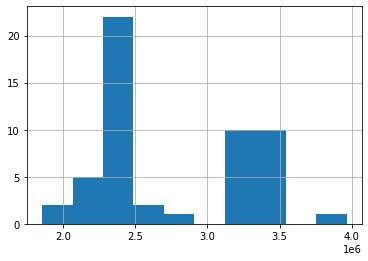

In [78]:
results={'id':list(test_df["id"]),'valormt2_predicted':list(tot_predictions)}
results=pd.DataFrame(results)
results["valormt2_predicted"]=results["valormt2_predicted"].apply(lambda x: x[0])
print(results.shape)
results.to_csv("results\\submission_rf2.csv",index=False)
results.valormt2_predicted.hist()

In [76]:
test_df["pr_mt2"]=test_df["valorventa"]/test_df["area"]

<AxesSubplot:>

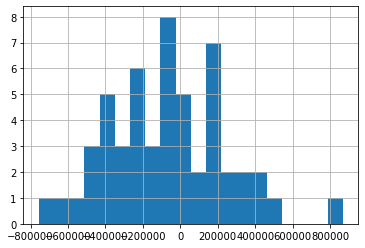

In [77]:
(test_df["pr_mt2"]-results["valormt2_predicted"]).hist(bins=20)

# Enfoque 4: Gradient Boosting Regressor

Utilizaremos el ensemble method de SKlearn. Este modelom es probado con el tratamiento de datos del enfoque 1. Buffer zone de 800 metros. 

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

In [48]:

params = {'n_estimators': 2000, 'max_features':0.2 , 'max_depth': 7, 'random_state': 123,
                   'min_samples_split': 20,'loss':"lad",'learning_rate':0.15}
gboost=GradientBoostingRegressor(**params)

In [49]:
gboost.fit(train_features,train_label)

GradientBoostingRegressor(learning_rate=0.15, loss='lad', max_depth=7,
                          max_features=0.2, min_samples_split=20,
                          n_estimators=2000, random_state=123)

Mean Absolute Error: 202699.94 degrees.
Mape:  6.68407 %.
Accuracy: 93.3159 %.
(53, 2)


<AxesSubplot:>

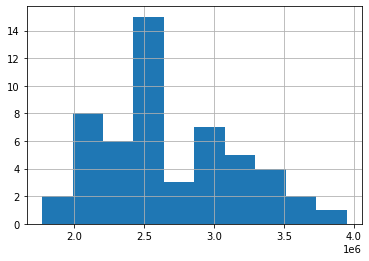

In [50]:
# Use the forest's predict method on the test data
predictions=gboost.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_label)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_label)
print("Mape: ",round(np.mean(mape),5), "%.")
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 4), '%.')
results={'id':list(test_df["id"]),'valormt2_predicted':list(predictions)}
results=pd.DataFrame(results)
print(results.shape)
results.to_csv("results\\submission_gboost.csv",index=False)
results.valormt2_predicted.hist()

# Calculando el promedio de las predicciones por unidad de obs:



In [81]:
os.getcwd()

'C:\\Users\\carli\\Dropbox\\Carlos Arturo Ramírez Pinto\\Files\\Universidad\\Kaggle\\El Algoritmo es Correcto'

AttributeError: module 'os' has no attribute '_dir_'

In [85]:
pred_1_rf=pd.read_csv("results\\submission_first_rf.csv")
pred_2_rf=pd.read_csv("results\\submission_rf2.csv")
pred_3_gb=pd.read_csv("results\\submission_gboost.csv")

In [89]:
final_results=pd.merge(pred_1_rf,pd.merge(pred_2_rf,pred_3_gb,how="inner",on="id"),how="inner",on="id")

In [93]:
final_results["mean_pred"]=final_results.iloc[:,[1,2,3]].apply(np.mean,axis=1)

In [94]:
# Calculate the absolute errors
errors = abs(final_results["mean_pred"] - test_label)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_label)
print("Mape: ",round(np.mean(mape),5), "%.")
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 4), '%.')

Mean Absolute Error: 187143.64 degrees.
Mape:  6.66709 %.
Accuracy: 93.3329 %.


In [95]:
mean_results=final_results[["id","mean_pred"]]

In [99]:
mean_results.columns=["id","valormt2_predicted"]

In [100]:
mean_results

,id,valormt2_predicted
0,877392,1.895273e+06
1,201483,3.141110e+06
2,188674,3.043127e+06
3,1211067,3.132145e+06
4,883437,3.418029e+06
5,332550,3.408535e+06
6,320585,3.418257e+06
7,776969,3.435355e+06
8,435344,1.967985e+06
9,1274573,3.083575e+06


In [102]:
mean_results.to_csv("results\\submission_mean.csv",index=False)